# MODEL 2: Predicting Human Preference Between model_a and model_b
##### Note: Model A and Model B do not specify a specific model (e.g. GPT-4 vs Claude, etc.). Rather, we are looking to understand human preferences using Model A as the "default" or the benchmark

### Results in this notebook differ from those presented earlier, reflecting additional statistical controls and methodological refinements applied post-presentation to improve rigor and interpretability. These updated results are reflected in the final paper submission.

In [1]:
!pip install textblob
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /srv/conda/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /srv/conda/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /srv/conda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /srv/conda/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /srv/conda/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /srv/conda/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [2]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [3]:
# Load and standardize data
df = pd.read_csv("ieor142a_sampled_dataset - Master Sheet.csv")
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Clean categorical columns
df['open/closed'] = df['open/closed'].str.strip().str.capitalize()
df['domain'] = df['domain'].str.strip().str.capitalize()

# Drop tie/bothbad and define target
df = df[df['winner'].isin(['model_a', 'model_b'])]
df['winner_binary'] = (df['winner'] == 'model_a').astype(int)

In [4]:
# Structural features
df['prompt_length'] = df['prompt'].apply(lambda x: len(str(x).split()))
df['response_a_length'] = df['response_a'].apply(lambda x: len(str(x).split()))
df['response_b_length'] = df['response_b'].apply(lambda x: len(str(x).split()))
df['response_length_diff'] = np.abs(df['response_a_length'] - df['response_b_length'])

# Sentiment features
def get_sentiment(text):
    if pd.isna(text):
        return 0
    return TextBlob(str(text)).sentiment.polarity

df['sentiment_a'] = df['response_a'].apply(get_sentiment)
df['sentiment_b'] = df['response_b'].apply(get_sentiment)
df['sentiment_diff'] = df['sentiment_a'] - df['sentiment_b']

# Features and target
categorical_features = ['open/closed', 'domain']
numeric_features = ['prompt_length', 'response_length_diff', 'sentiment_diff']
df = df.dropna(subset=categorical_features + numeric_features)
X = df[categorical_features + numeric_features]
y = df['winner_binary']

In [5]:
# PART 1: SKLEARN PIPELINE

# Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numeric_features)
])

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Stratified split on open/closed
stratify_labels = X['open/closed']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=stratify_labels
)

pipeline.fit(X_train, y_train)

# Evaluation
y_pred = pipeline.predict(X_test)
print("Human Preference Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Coefficients for visualization
ohe = pipeline.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_features = ohe.get_feature_names_out(categorical_features).tolist()
feature_names = encoded_cat_features + numeric_features
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': pipeline.named_steps['classifier'].coef_[0]
})

Human Preference Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.24      0.31        41
           1       0.48      0.69      0.57        42

    accuracy                           0.47        83
   macro avg       0.46      0.47      0.44        83
weighted avg       0.46      0.47      0.44        83

Confusion Matrix:
 [[10 31]
 [13 29]]


In [6]:
# PART 2: STATS MODELS FOR RIGOR

# One-hot encode manually
X_stats = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Standardize numeric features
scaler = StandardScaler()
X_stats[numeric_features] = scaler.fit_transform(X_stats[numeric_features])

# Split with same stratification
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_stats, y, test_size=0.2, random_state=42, stratify=stratify_labels
)

# Add intercept
X_train_s = sm.add_constant(X_train_s)

# Convert all bool columns to int
X_train_s = X_train_s.astype({col: 'int' for col in X_train_s.select_dtypes('bool').columns})

# Fit logistic regression with statsmodels
logit_model = sm.Logit(y_train_s, X_train_s)
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.687451
         Iterations 4


                          Results: Logit
Model:                Logit             Method:            MLE     
Dependent Variable:   winner_binary     Pseudo R-squared:  0.006   
Date:                 2025-05-10 20:44  AIC:               474.4672
No. Observations:     332               BIC:               508.7134
Df Model:             8                 Log-Likelihood:    -228.23 
Df Residuals:         323               LL-Null:           -229.64 
Converged:            1.0000            LLR p-value:       0.94593 
No. Iterations:       4.0000            Scale:             1.0000  
-------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------
const                 0.1069   0.3193  0.3348 0.7378 -0.5189 0.7327
prompt_length        -0.0491   0.1106 -0.4436 0.6573 -0.2658 0.1677
response_length_diff  0.0195   0.1118  0.1740 0.8619 -0.1996 0.2385
sentime

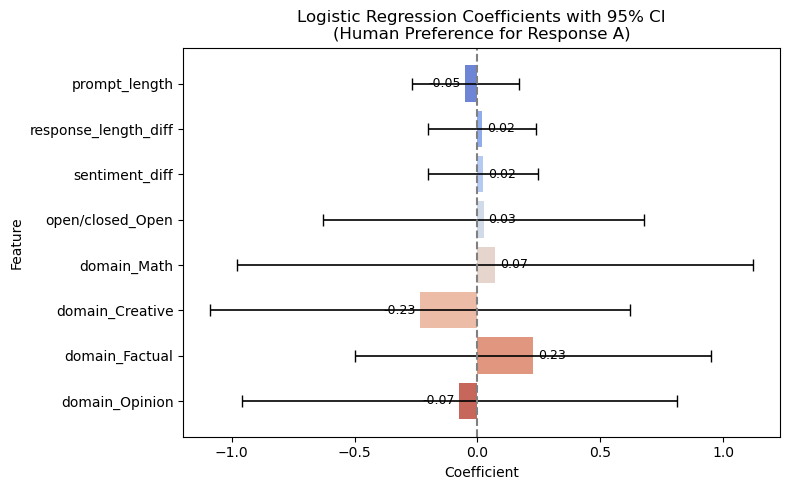

In [7]:
# Display full summary
print(result.summary2().as_text())

summary_df = result.summary2().tables[1].reset_index().rename(columns={
    'index': 'Feature',
    'Coef.': 'Coefficient',
    'Std.Err.': 'Std_Error',
    'P>|z|': 'P_Value',
    '[0.025': 'CI_Lower',
    '0.975]': 'CI_Upper'
})

# Re-order features logically
ordered_features = [
    'prompt_length',
    'response_length_diff',
    'sentiment_diff',
    'open/closed_Open',
    'domain_Math',
    'domain_Creative',
    'domain_Factual',
    'domain_Opinion'
]
summary_df = summary_df.set_index('Feature').loc[ordered_features].reset_index()

# Plot with error bars using seaborn barplot
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x='Coefficient',
    y='Feature',
    data=summary_df,
    hue='Feature',
    palette='coolwarm',
    legend=False,
    orient='h'
)

# Add 95% CI error bars manually
for i, row in summary_df.iterrows():
    ax.errorbar(
        x=row['Coefficient'],
        y=i,
        xerr=[[row['Coefficient'] - row['CI_Lower']], [row['CI_Upper'] - row['Coefficient']]],
        fmt='none',
        capsize=4,
        color='black',
        linewidth=1.2
    )

# Add coefficient labels
for i, row in summary_df.iterrows():
    ax.text(
        x=row['Coefficient'] + 0.02 if row['Coefficient'] > 0 else row['Coefficient'] - 0.02,
        y=i,
        s=f"{row['Coefficient']:.2f}",
        va='center',
        ha='left' if row['Coefficient'] > 0 else 'right',
        fontsize=9
    )

# Draw vertical reference line at 0
plt.axvline(0, color='gray', linestyle='--')
plt.title("Logistic Regression Coefficients with 95% CI\n(Human Preference for Response A)")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()